<a href="https://colab.research.google.com/github/CAVA1611/neural-networks/blob/main/TFM_Reddit_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción con Series Temporales de la carga en un centro de datos

**Autor:** Cesar Velasco Arias

In [2]:
# Importacion de librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
from time import sleep
import re 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(80)
random.seed(80)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path = '/content/drive/MyDrive/TFM/csv_2019'
year = '2019'

In [4]:

def files_verification():
  meses = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  list_dir=[]
  files_to_read=[]
  files_not_found=[] 
  count = 0 
  try:
    list_dir = os.listdir(path)
    if os.path.isdir(path) and len(list_dir)>0:
      for mes in meses:
        file_to_read = 'LoadReddit-60minutes-'+ str(year)+'-'+ str(mes)+'-PLN.csv'
        if os.path.isfile(os.path.join(path, file_to_read)):
            count+=1
            files_to_read.append(file_to_read)
        else:
          files_not_found.append(file_to_read)
  except:  
    print('No se ha encontrado el directorio')
  
  print('Se han encontrado: {} correspondientes al año {}'.format(count,year))
  for f in files_to_read:
    print('-',f)
  print('\nHace falta {} archivos'.format(12-count))
  for nf in files_not_found:
    print('-',nf)
  print('\n')
  return files_to_read

In [5]:

def data_reading(path, year):
  global df
  meses = {'enero': '01', 'febrero':'02', 'marzo':'03', 'abril':'04', 'mayo':'05', 
           'junio':'06', 'julio':'07', 'agosto':'08','septiembre':'09',
           'octubre':'10', 'noviembre':'11', 'diciembre':'12'}
  month_conc = []
  files_to_read = files_verification()    
  for mes_k, mes_v in zip(meses.keys(), meses.values()):
    for file in files_to_read:
      pa = file.split('-')
      for p in pa:
        if p == mes_v:
          mes_k = pd.read_csv(os.path.join(path, file), 
                              header=None, names=['Date', 'number_of_post'], 
                              parse_dates=['Date']) 
          month_conc.append(mes_k)
          #print('Dimension para el mes {}: {}'.format(mes_k,mes_k.shape))
  df = pd.concat(month_conc, axis=0)
  print('*'*30)
  print('\nDimension de df -> ',df.shape)

  return (df, meses)

In [6]:
def graphic_1(start_month,end_month,year):
  global df_time, train_scaler, test_scaler, steps
  
  df_time, meses = data_reading(path, year)
  df_time = df_time.set_index('Date')
  for mes_k, mes_v in zip(meses.keys(), meses.values()):
    if start_month == mes_k:
      start_month_index = mes_v
  for mes_k, mes_v in zip(meses.keys(), meses.values()):
    if end_month == mes_k:
      end_month_index = mes_v
  if start_month_index > end_month_index:
    print("Mal ingreso de mes, el mes de inicio no puede ser despues del segundo")
  else:
    print("Datos para graficar desde {} hasta {}".format(start_month, end_month))
    steps = int(len(df_time)*0.2)
    train = df_time[:-steps]
    test  = df_time[-steps:]
    max = train.max()
    min = train.min()
    train_scaler=  train['number_of_post'].apply(lambda x: (x-min)/(max-min))
    test_scaler= test['number_of_post'].apply(lambda x: (x-min)/(max-min)) 
    fig, (ax1, ax2)=plt.subplots(2, figsize=(20, 8))
    df_time.plot(ax=ax1, grid=True)
    train_scaler.plot(ax=ax2, grid=True)
    test_scaler.plot(ax=ax2, grid=True)
    ax1.legend(['Datos'])
    ax2.legend(['Train', 'Test'])
    ax1.set_title('Datos Originales')
    ax2.set_title('Datos Normalizados')
    plt.subplots_adjust(hspace=0.8)
  


In [7]:
def data_for_rn(df_train, df_test, n_obs):
  #n_obs -> es el numero de observacione que se toman para predecir un valor
  # Con los datos de train se debe dividir en un array "X_train" y  "y_train"; este es un formato necesario para la prediccion en series
  # temporales. En "X_train" se encontaran el numero de observaciones que leera el modelo para predecir y en "y_train" se encontrara
  # el valor a predecir. 
  # Ambos tendran la misma dimension en cuanto a numero de filas.
  # Para el caso de este trabajo se ha escogido como numero de observaciones 20, es decir que se leeran 20 datos para predecir 1

  Obs = n_obs
  X_train = np.atleast_3d(np.array([df_train[start:start + Obs] for start in range(0, df_train.shape[0] - Obs)]))
  y_train = df_train[Obs:]

  # Para probar el modelo entrenado con los datos de test se tiene que colocar en el mismo formato.
  X_test = np.atleast_3d(np.array([df_test[start:start + Obs] for start in range(0, df_test.shape[0] - Obs)]))
  y_test = df_test[Obs:]
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  
  return (X_train, y_train, X_test, y_test)


  

In [8]:
def graphic_predict(df_predicted):
  #grafico de los valores de test y los valores predichos 
  fig, (ax1, ax2)=plt.subplots(2, figsize=(20, 8))
  train_scaler.plot(ax=ax1, grid=True)
  test_scaler.plot(ax=ax1, grid=True)
  df_predicted.plot(ax=ax1, grid=True)
  ax1.legend(['Train', 'Test', 'Test Predict'])
  ax1.set_title('DATOS CON LA PREDICCION ')
  test_scaler.plot(ax=ax2, grid=True)
  df_predicted.plot(ax=ax2, grid=True)
  ax2.legend(['Test', 'Test Predict'])
  ax2.set_title('MES DE PREDICCION')
  plt.subplots_adjust(hspace=0.8)
  

In [42]:
def prediction(modelo, X_test):
  layers=[]
  
  test_pred = modelo.predict(X_test)
  for layer in modelo.layers:
    layers.append(layer.name)
  n_neur = modelo.layers[1].get_output_shape_at(0)
  if len(layers) <4:
    RESULTADOS.loc['Modelo '+ layers[1] + '-' + str(n_neur[1])] = (math.sqrt(mean_squared_error(y_test, test_pred)))

  # Aumento de  valores para poder graficar junto con los valorres de test
  mat = np.array(n_obs*[np.nan])
  test_pred_2 = np.append([mat], [test_pred])
  test_pred_plot = pd.DataFrame(test_pred_2, columns=['num_pred_test'])
  
  # Para grafica
  df_time_3 = df_time[-steps:]
  test_pred_plot['index'] = df_time_3.index
  df_time_predict_test = test_pred_plot.set_index('index')
  graphic_predict(df_time_predict_test)

  RESULTADOS


  

## Lectura y Grafica de datos

Se han encontrado: 10 correspondientes al año 2019
- LoadReddit-60minutes-2019-01-PLN.csv
- LoadReddit-60minutes-2019-02-PLN.csv
- LoadReddit-60minutes-2019-04-PLN.csv
- LoadReddit-60minutes-2019-05-PLN.csv
- LoadReddit-60minutes-2019-06-PLN.csv
- LoadReddit-60minutes-2019-07-PLN.csv
- LoadReddit-60minutes-2019-08-PLN.csv
- LoadReddit-60minutes-2019-10-PLN.csv
- LoadReddit-60minutes-2019-11-PLN.csv
- LoadReddit-60minutes-2019-12-PLN.csv

Hace falta 2 archivos
- LoadReddit-60minutes-2019-03-PLN.csv
- LoadReddit-60minutes-2019-09-PLN.csv


******************************

Dimension de df ->  (7291, 2)
Datos para graficar desde enero hasta diciembre


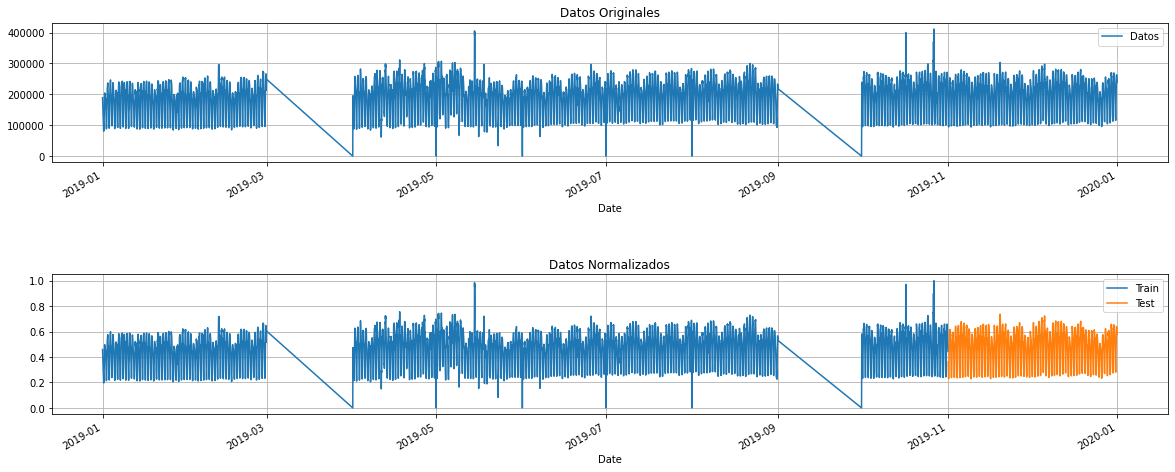

In [17]:
start_month = 'enero'
end_month = 'diciembre'
graphic_1(start_month,end_month,year)
  
# Tabla de resultados
RESULTADOS = pd.DataFrame(columns=['RMSE'])

In [12]:
# Obtener "X" y "y" train y test para las redes neuronales (solo es necesario realizar una vez)
# se trabaja con los datos escalados
n_obs = 20

(X_train, y_train, X_test, y_test) = data_for_rn(train_scaler, test_scaler, n_obs)

print("Dimension de X_train: ", X_train.shape)
print("\nDimension de y_train: ", y_train.shape)
print("\nDimension de X_test: ", X_test.shape)
print("\nDimension de y_test: ", y_test.shape)


Dimension de X_train:  (5813, 20, 1)

Dimension de y_train:  (5813, 1)

Dimension de X_test:  (1438, 20, 1)

Dimension de y_test:  (1438, 1)


## Componentes de la Serie Temporal

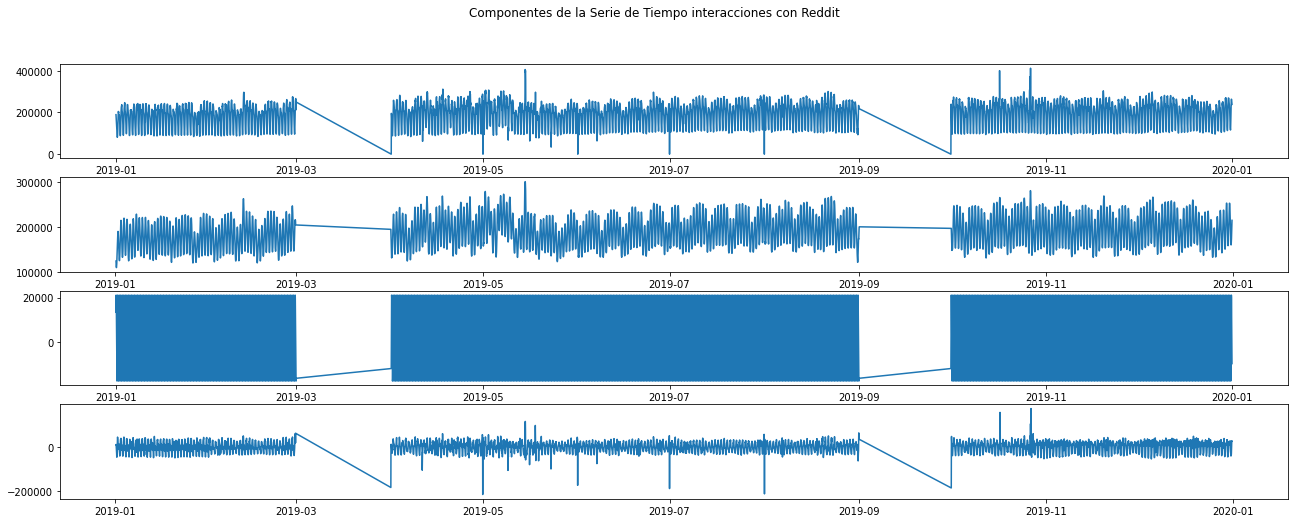

In [13]:
# funcion seasonal_decompose() para observar las 3 componentes de las series de tiempo:
# - Trend
# - Seasonal
# - Resid
components = seasonal_decompose(df_time, model='additive', freq=12) # (df_time)
fig, axs = plt.subplots(4,figsize=(22, 8))
fig.suptitle('Componentes de la Serie de Tiempo interacciones con Reddit')
axs[0].plot(components.observed)
axs[1].plot(components.trend)
axs[2].plot(components.seasonal)
axs[3].plot(components.resid)

## LSTM




In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) # para evatir el overfiting

In [15]:
model_lstm_1 = Sequential()
visible = Input(shape=(X_train.shape[-2:]))
hidden1 = LSTM(64)(visible)
output = Dense(1, activation='linear')(hidden1)
model_lstm_1 = Model(inputs=visible, outputs=output)
model_lstm_1.compile(optimizer='sgd', loss='mean_squared_error')
history = model_lstm_1.fit(X_train, y_train, batch_size=20, epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

# resumen de  capas
model_lstm_1.summary()

Epoch 1/100
291/291 [==============================] - 9s 9ms/step - loss: 0.0228 - val_loss: 0.0167
Epoch 2/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 3/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 4/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 5/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 6/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 7/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 8/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 9/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 10/100
291/291 [==============================] - 2s 7ms/step - loss: 0.0090 - val_lo

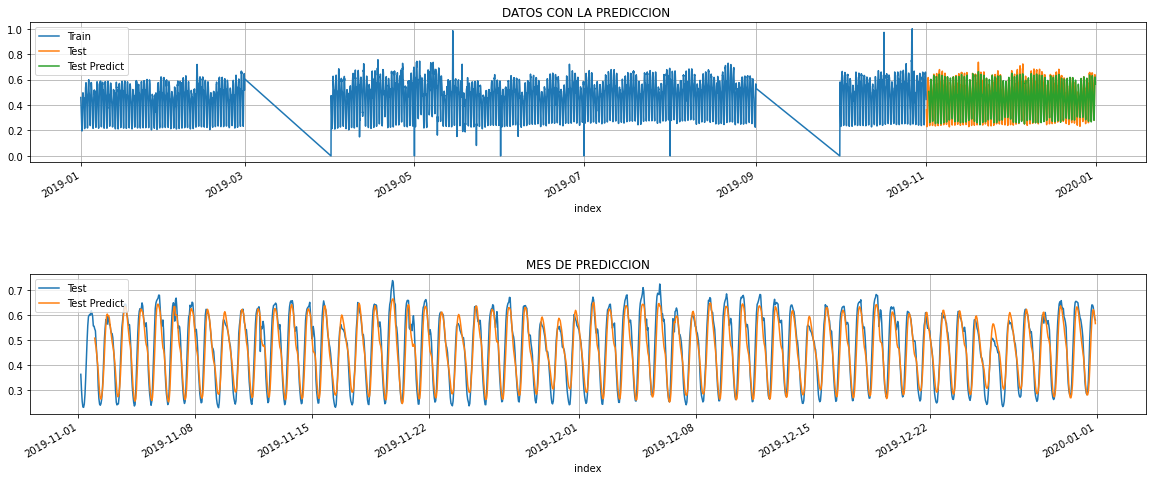

In [43]:

prediction(model_lstm_1, X_test)
  

In [ ]:
RESULTADOS
    

In [56]:
layers=[]
for layer in model_lstm_1.layers:
  layers.append(layer.name)
print(layers[1])

lstm_4


In [ ]:
layers=[]
for layer in model_lstm_1.layers:
  print(layer)
  layers.append(layer)
  print(layers)
  if len(layers)>1:
    print("Aqui va el shape")
    print(layer.get_output_shape_at(1))

In [39]:
aux = model_lstm_1.layers[1].get_output_shape_at(0)
print(aux[1])

64
